In [ ]:
#set seed to get consistent values
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [ ]:
#importing our dependencies
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [ ]:
!pip install kaggle

In [ ]:
kaggle = json.load(open("kaggle.json"))

In [ ]:
# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle["username"]
os.environ['KAGGLE_KEY'] = kaggle["key"]

In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

 95% 186M/195M [00:03<00:00, 81.6MB/s]
100% 195M/195M [00:03<00:00, 58.0MB/s]


In [ ]:
!ls

breast-ultrasound-images-dataset.zip  drive  kaggle.json  sample_data


In [ ]:
# Unzip the downloaded dataset
with ZipFile("breast-ultrasound-images-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
print(os.listdir("Dataset_BUSI_with_GT"))

print(len(os.listdir("Dataset_BUSI_with_GT")))

['normal', 'benign', 'malignant']
3


**DATA PREPROCESSING**

(585, 683, 3)


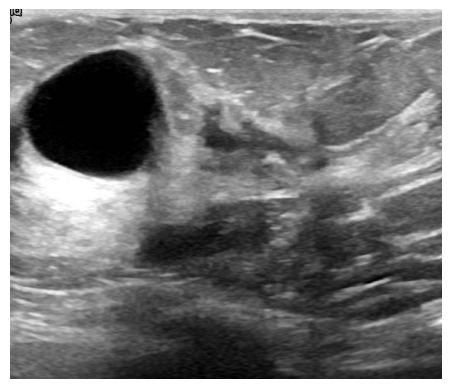

In [ ]:
image_path = "/content/Dataset_BUSI_with_GT/benign/benign (10).png"

# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [ ]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # Use 20% of data for validation

In [ ]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    '/content/Dataset_BUSI_with_GT',
    target_size=(224, 224),
    batch_size=32,
    subset='training',
    class_mode= 'categorical'
)

Found 1263 images belonging to 3 classes.


In [ ]:

# Validation Generator
validation_generator = data_gen.flow_from_directory(
  '/content/Dataset_BUSI_with_GT',
    target_size=(224, 224),
    batch_size=32,
    subset='validation',
    class_mode='categorical'
)


Found 315 images belonging to 3 classes.


**CNN MODEL**

In [ ]:
# Model Definition
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))


model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

In [ ]:

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 256)               4

In [ ]:
# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**MODEL TRAINING**

In [ ]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,  # Number of steps per epoch
    epochs=5,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32  # Validation steps
)

Epoch 1/5
39/39 [==============================] - 34s 755ms/step - loss: 1.8416 - accuracy: 0.5110 - val_loss: 0.8492 - val_accuracy: 0.5868
Epoch 2/5
39/39 [==============================] - 26s 685ms/step - loss: 0.7693 - accuracy: 0.6531 - val_loss: 0.7488 - val_accuracy: 0.6944
Epoch 3/5
39/39 [==============================] - 25s 636ms/step - loss: 0.6613 - accuracy: 0.7181 - val_loss: 0.7177 - val_accuracy: 0.7014
Epoch 4/5
39/39 [==============================] - 29s 758ms/step - loss: 0.6428 - accuracy: 0.7238 - val_loss: 0.6833 - val_accuracy: 0.6910
Epoch 5/5
39/39 [==============================] - 25s 648ms/step - loss: 0.5788 - accuracy: 0.7360 - val_loss: 0.7309 - val_accuracy: 0.7188


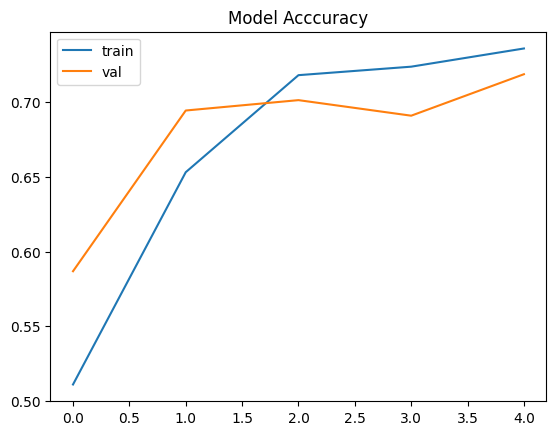

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Acccuracy')

plt.legend()

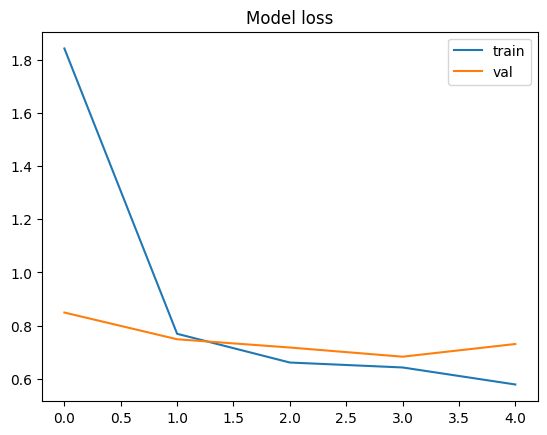

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model loss')


plt.legend()

**BUILD PREDICTIVE SYSTEM**

In [ ]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [ ]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [ ]:
class_indices

{0: 'benign', 1: 'malignant', 2: 'normal'}

In [ ]:
# saving the class names as json file
json.dump(class_indices, open('class_indices.json', 'w'))

In [ ]:
# Testing our model
image_path = '/content/Dataset_BUSI_with_GT/benign/benign (10).png'
predicted_class_name = predict_image_class(model, image_path, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 218ms/step
Predicted Class Name: benign


In [ ]:
#saving our model in google drive
model.save('/content/drive/MyDrive/trained_models/breast_cancer_prediction_model.h5')